In [1]:
# Probabilistic curve fitting, express
# uncertainty over target t using a gaussian
# (aka normal) distribution
%pylab inline
def gaussian(x, mu, sigma):
    # vectorised for multiple x, sigma
    # returning x varying in the 1st dimension (down), sigma in the 2nd (right)
    numerator = np.exp(-0.5 * array(mat(x - mu).T * mat(1./sigma))**2)
    return 1./(np.sqrt(2*np.pi)*sigma)*numerator

def cond_pdf_t(t, x, w, sigma):
    """Probability of t given x, y, sigma"""
    return gaussian(t, polyval(w,x), sigma)


from IPython.display import display, Math, Latex

Populating the interactive namespace from numpy and matplotlib


Text(0.5, 0, 'x')

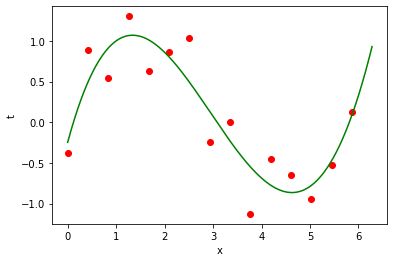

In [2]:
# Do polynomial fitting like before, for now just
# trusting the built-in polyfit
# We sample from a sin curve with added gaussian noise
# of std dev 0.3

N = 15 # training points
M = 4  # polynomial degree

x = arange(0, 2*pi, (2*pi)/N)
noise = 0.3 * randn(N)
t = sin(x) + noise
plot(x,t,'ro')

w = polyfit(x, t, M)
xs = arange(0,2*pi,.01)
plot(xs, polyval(w, xs), 'g')
ylabel("t")
xlabel("x")

Text(0.5, 1.0, '$p(t|x,$w$,\\sigma)$')

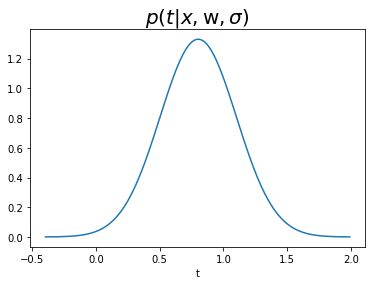

In [3]:
# Consider the probability distibution for
# the predicted value of t at a certain x
# position, eg one of our training points

xvalue = x[5]

# From above, we are assuming it is distributed
# normally, with mean given as the value of our
# polynomial, and for now lets pick 0.3 as a standard
# deviation (cheating, because we know that is the 
# real value from the noise)

tmean = polyval(w, xvalue)
sigma = 0.3

# We plot over the domain +-4 standard deviations,
# using the conditional probability function defined earlier
ts = arange(tmean-4*sigma, tmean+4*sigma, 0.01)
pdf_t = cond_pdf_t(ts, xvalue, w, sigma)

plot(ts, pdf_t)

xlabel("t")
title("$p(t|x,$w$,\sigma)$", fontsize=20)

# As expected, it is just a normal distribution

Text([3.4242027], 0.8019421131641933, '  $p(t|x,$w$,\\sigma)$')

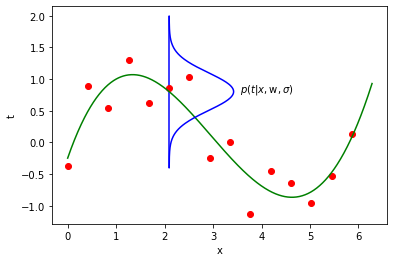

In [4]:
plot(x,t,'ro')
plot(xs, polyval(w, xs), 'g')

# Now, to illustrate, we plot this gaussian sideways
# over our graph, showing how its width (standard deviation)
# expresses our uncertainty in the value of t

def plot_sideways(x, y, zeropos, *args, **kwargs):
    # Plot sideways by switching x and y, adding zeropos
    # to our y to change the location
    plot(y + zeropos, x, *args, **kwargs)
    # Draw a vertical line for the axis
    vlines(zeropos, min(x), max(x), *args, **kwargs)
    
plot_sideways(ts, pdf_t, xvalue, 'b')

ylabel("t")
xlabel("x")
text(xvalue + max(pdf_t), polyval(w,xvalue), "  $p(t|x,$w$,\sigma)$")

We can also plot probability as color in the 2d plane.

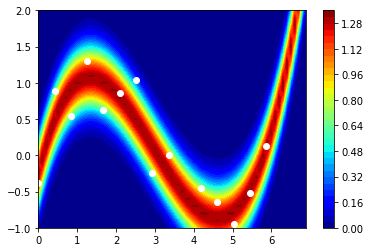

In [5]:
X,Y = meshgrid(arange(0,7,0.1),arange(-1,2.1,0.1))
Z = [cond_pdf_t(Yi,Xi,w,sigma) for Xi,Yi in zip(X,Y)]
Z = array(Z).reshape(X.shape)
jet()
contourf(arange(0,7,0.1), arange(-1,2.1,0.1), Z, levels=40)
colorbar()
xlim([0,6.9])
ylim([-1,2])
scatter(x,t,c='w')

In [6]:
# So, now the question is how do we learn the weights w
# and the standard deviation sigma from our training data

# Well, we can see how probable each training point is given some
# weights and standard deviation using our conditional probability
# density function (now working on a vector of training data rather than a scalar)
# (note these values are not probabilities, hence may be >1)

print(cond_pdf_t(t, x, w=[0.01, -0.02, -0.5, 1.7, -0.4], sigma=0.3))

[[1.32553585]
 [0.11718557]
 [1.22835099]
 [0.61759085]
 [0.53579397]
 [1.23106725]
 [0.9629209 ]
 [0.05338001]
 [1.08959831]
 [0.0064887 ]
 [1.32973981]
 [1.32810898]
 [0.79024069]
 [1.23107637]
 [1.31759643]]


In [7]:
# But we want to know how probable all the data is -- for this
# we use the product rule, assuming the data was drawn independently, 
# simply multiplying all the previous values

p = product(cond_pdf_t(t, x, w=[0.01, -0.02, -0.5, 1.7, -0.4], sigma=0.3), 0)


Math("$p(\mathbf{t}|\mathbf{x},\mathbf{w},\sigma) = \prod_{n=1}^{N} Norm(t_n|y(x_n,\mathbf{w}),\sigma) = %f$" % p)

# This is the value we want to maximise - try tweaking the parameters
# to get a high value, it probably isn't easy!

<IPython.core.display.Math object>

Text(0, 0.5, 'Likelihood')

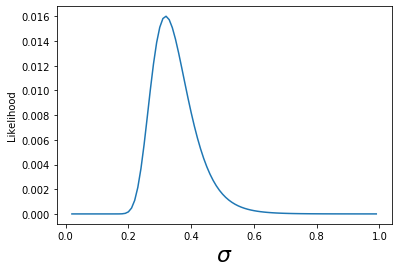

In [8]:
# When considered as a function of w and sigma, this is our
# likelihood function, and is *not* a probability distribution
# over these variables. Note that syntactically it is the same
# expression as a conditional probability dist on t, it is just
# a matter of which variables we "fix" and which we "slide around". 

def likelihood_w_sigma(w, sigma):
    return product(cond_pdf_t(t, x, w, sigma), 0)

# We can plot likelihood against different standard deviation
# to see where the maximum is - how does this compare to the sd
# we actually set for the noise?

sigs = arange(0.02,1,0.01)
plot(sigs, likelihood_w_sigma(w, sigs))
xlabel("$\sigma$", fontsize=22)
ylabel("Likelihood")

Text(0, 0.5, 'NLL')

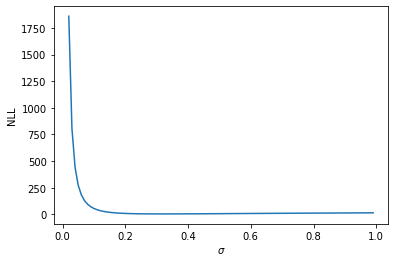

In [9]:
# In practice we consider the log of the likelihood, which lets us
# turn the product into a sum and avoids numerical underflow
# from multiplying small values. We want to maximise the log likelihood,
# or equivalently, minimise the negative log likelihood

def nlog_likelihood_w_sigma(w, sigma):
    # log(product(cond_pdf_t(t, x, w, sigma),0))
    # = sum(log(cond_pdf_t(t, x, w, sigma)), 0)
    # using negative:
    return -sum(log(cond_pdf_t(t, x, w, sigma)), 0)

plot(sigs, nlog_likelihood_w_sigma(w, sigs))
xlabel('$\sigma$')
ylabel('NLL')

Maximum Likelihood Solution
===========================

The Maximum Likelihood solution can be found in closed form.

First we can use the properties of the (natural) log to simplify the formula

$\log(p(\mathbf{t}|\mathbf{x}, \mathbf{w},\sigma)) = \log(\prod_{n=1}^{N} Norm(t_n|y(x_n,\mathbf{w}),\sigma))$

$ = \sum_{n=1}^{N} \log[(2\pi\sigma^2)^{-1/2} \exp(-\frac{(t_n-y(x_n,\mathbf{w}))^2}{2\sigma^2})]$
      
$ = N \log((2\pi\sigma^2)^{-1/2}) -\frac{1}{2\sigma^2} \sum_{n=1}^{N} (t_n-y(x_n,\mathbf{w}))^2 $
      
$ = -\frac{1}{2\sigma^2} \sum_{n=1}^{N} (t_n-y(x_n,\mathbf{w}))^2 - \frac{N}{2}\log(\sigma^2)  - \frac{N}{2}\log(2\pi) $

Now we can find the gradient wrt $\mathbf{w}$ and $\sigma^2$

(TODO)

In polynomial regression, the hypothesis, $y$, is of the form:

$y(x_n, \mathbf{w}) = \sum_{i=0}^{M} w_i x^{i}$, where $M-1$ is the degree of the polynomial (we started at 0).

Using matrix notation, let $\mathbf{w} = w_1 ... w_M$, a vector of weights. Also, let $\mathbf{x_n} = x_n^{0}...x_n^{M}$, a vector of the first $M$ powers of $x_n$.

Then, $y(x_n, \mathbf{w}) = \mathbf{w}^{T}\mathbf{x_n}$

The derivative of $y(x_n, \mathbf{w})$ wrt $\mathbf{w}$ will come in handy soon, and we can see that: $\frac{d y}{d \mathbf{w}} = \mathbf{x_n}$ by the linearity of $\mathbf{w}^{T}\mathbf{x_n}$.

Another point of notation, we'll introduce the design matrix, $X$, in which each training example is a row and each power of $x_n$ is a column.

Taking the derivative of $-\frac{1}{2\sigma^2} \sum_{n=1}^{N} (t_n-y(x_n,\mathbf{w}))^2 - \frac{N}{2}\log(\sigma^2)  - \frac{N}{2}\log(2\pi) $ with respect to $\mathbf{w}$, we obtain:

$ -\sum_{n=1}^{N}(t_n - y(x_n, \mathbf{w})) \frac{d y}{d \mathbf{w}}$, using the fact that constants are irrelevant in minimization and we don't care about scalar multiples of the gradient.

Replacing $\frac{d y}{d \mathbf{w}}$ with what we computed earlier, 

$ = -\sum_{n=1}^{N}(t_n - y(x_n, \mathbf{w}))\mathbf{x_n}$

$ = -\sum_{n=1}^{N}(t_n - \mathbf{w}^{T}\mathbf{x_n})\mathbf{x_n}$

Now using the design matrix to simplify things, and letting $\mathbf{t} = t_1 ... t_N$, the vector of targets, we can compute the $M$ dimensional gradient of the weights with respect to the error:

$ = -\sum_{n=1}^{N}(t_n \mathbf{x_n}) + \sum_{n=1}^{N}(\mathbf{w}^{T}\mathbf{x_n})\mathbf{x_n}$

$ = -X^{T}\mathbf{t} + X^{T}(X\mathbf{w}) $

And since we are at an optima when this gradient is zero,

$ 0 = -X^{T}\mathbf{t} + X^{T}(X\mathbf{w}) $

$ X^{T}\mathbf{t} =  (X^{T}X)\mathbf{w} $

Almost there! Using the fact that $X^{T}X$ has a pseudoinverse, 

$ \mathbf{w} = (X^{T}X)^{-1}X^{T}\mathbf{t} $

And we have a closed form solution for the weights. This solution is refered to as the "normal equation". Note for big-data problems, the performance of this equation is pretty poor, and a much fa